In [21]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import save_image
from torchvision import transforms
from tqdm.notebook import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
from tensorboardX import SummaryWriter
from torchinfo import summary
import math

# Import des données CIFAR10

In [2]:
device = torch.device("cuda")
trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
data_train = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
data_test = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
classes = trainset.classes

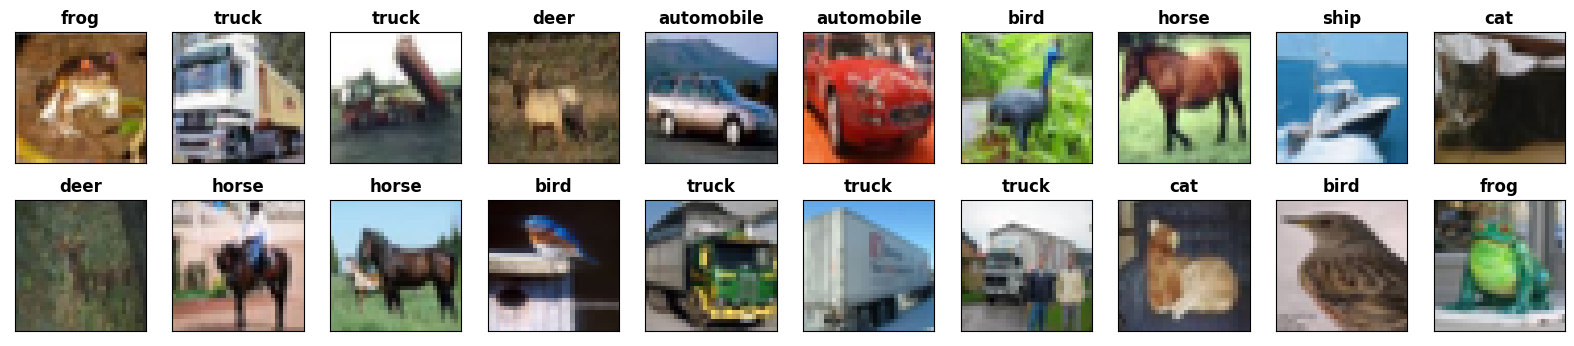

In [4]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(trainset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(trainset[i + number][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i + number][1]]}", fontweight="bold")
plt.show()

In [5]:
trainset[0][0].shape, len(trainset)

(torch.Size([3, 32, 32]), 50000)

# FID

In [8]:
fid = FrechetInceptionDistance(feature=2048, normalize=True, reset_real_features=False,
                               compute_on_cpu=True).to(device)

Calcul des features du vrai jeu de données, et stockage de la moyenne et matrice de covariance obtenue pour comparaison avec les données générées à chaque epoch

In [9]:
for data in tqdm(data_train):
    fid.update(data[0].to(device), real=True)

  0%|          | 0/1563 [00:00<?, ?it/s]

# Simple diffusion model

In [10]:
embedding = nn.Embedding(10, 3)

In [14]:
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
input

tensor([[1, 2, 4, 5],
        [4, 3, 2, 9]])

In [12]:
input.shape

torch.Size([2, 4])

In [13]:
emb = embedding(input)
emb.shape

torch.Size([2, 4, 3])

In [15]:
emb

tensor([[[ 1.2545, -0.8333,  0.9868],
         [-0.8285, -1.9264, -1.4586],
         [-1.8771, -1.1657, -0.6710],
         [ 0.4870, -1.3385, -0.4094]],

        [[-1.8771, -1.1657, -0.6710],
         [ 0.4418, -0.8163,  1.2058],
         [-0.8285, -1.9264, -1.4586],
         [ 1.4764, -1.0966, -0.3933]]], grad_fn=<EmbeddingBackward0>)

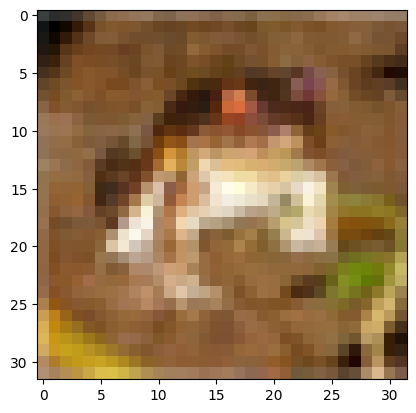

In [23]:
plt.imshow(trainset[0][0].view(3, 32, 32).permute(1,2,0))

In [32]:
trainset[0][0]

tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

$$ q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_0, \beta_t I)$$

In [64]:
# https://github.com/acids-ircam/diffusion_models/blob/main/diffusion_02_model.ipynb
def forward_process(x_0, T, betas):
    X = [x_0]
    for t in range(T):
        noise = (torch.sqrt(1 - betas[t]) * X[-1]) + (betas[t] * torch.rand_like(x_0))
        # On renormalise sur [0, 1]
        X.append(noise/torch.max(noise))
    return X

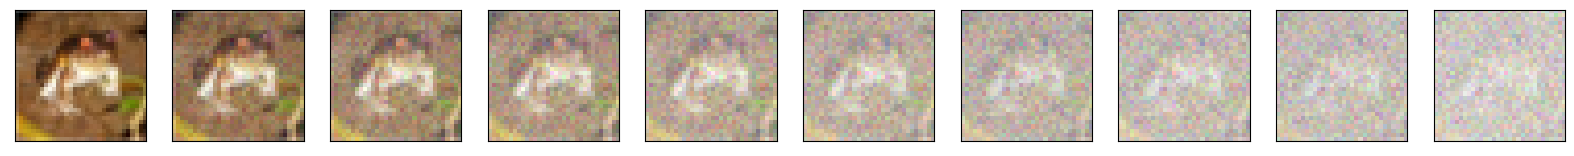

In [65]:
T = 100
# beta constant
betas = 0.035 * torch.ones(T)
X = forward_process(trainset[0][0], T, betas)
plt.figure(figsize=(20, 2))
number = 10
for i in range(number):
    ax = plt.subplot(1, number, i + 1)
    plt.imshow(X[i * 10].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [6]:
type(trainset[i][0].view(3, 32, 32).permute(1,2,0))

torch.Tensor

In [13]:
for i in range(50):
    save_image(trainset[i][0].view(3, 32, 32), f"images/{i}.png")

# Denoising Diffusion Probabilistic Models

Inspiré de : https://github.com/awjuliani/pytorch-diffusion <br>
Code relativement simple et efficace, suffisant pour un 1er essai

In [12]:
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value


class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x


# U-Net code adapted from: https://github.com/milesial/Pytorch-UNet
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class DiffusionModel(nn.Module):
    def __init__(self,t_range):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = t_range
        self.device = torch.device("cuda")

        bilinear = True
        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, 3)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

    def beta(self, t):
        return self.beta_small + (t / self.t_range) * (
            self.beta_large - self.beta_small
        )

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        return math.prod([self.alpha(j) for j in range(t)])

    #def get_loss(self, batch, batch_idx):
    def get_loss(self, batch):
        """
        Corresponds to Algorithm 1 from (Ho et al., 2020).
        """
        ts = torch.randint(0, self.t_range, [batch.shape[0]], device=self.device)
        noise_imgs = []
        epsilons = torch.randn(batch.shape, device=self.device)
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append((math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i]))
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float))
        loss = F.mse_loss(e_hat.reshape(-1, 32*32), epsilons.reshape(-1, 32*32))
        return loss

    def denoise_sample(self, x, t):
        """
        Corresponds to the inner loop of Algorithm 2 from (Ho et al., 2020).
        """
        with torch.no_grad():
            if t > 1:
                z = torch.randn(x.shape)
            else:
                z = torch.zeros(1)
            e_hat = self.forward(x, t.view(1, 1).repeat(x.shape[0], 1)).to(device)
            pre_scale = (1 / math.sqrt(self.alpha(t)))
            e_scale = ((1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))).to(device)
            post_sigma = (math.sqrt(self.beta(t)) * z).to(device)
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("val/loss", loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

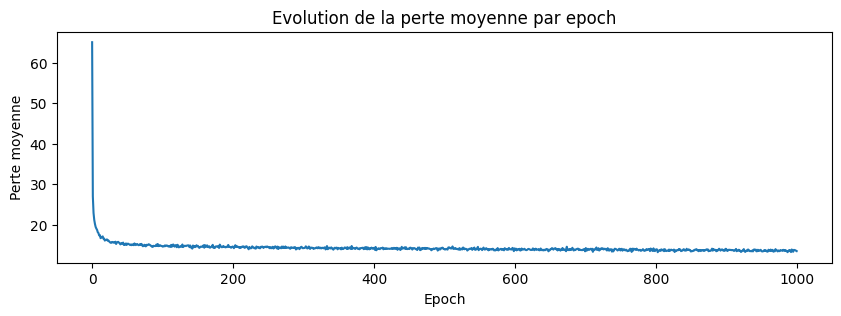

In [17]:
loss_1000e = np.load("losses/loss_1000e.npy")
plt.figure(figsize=(10, 3))
plt.plot(loss_1000e)
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.show()

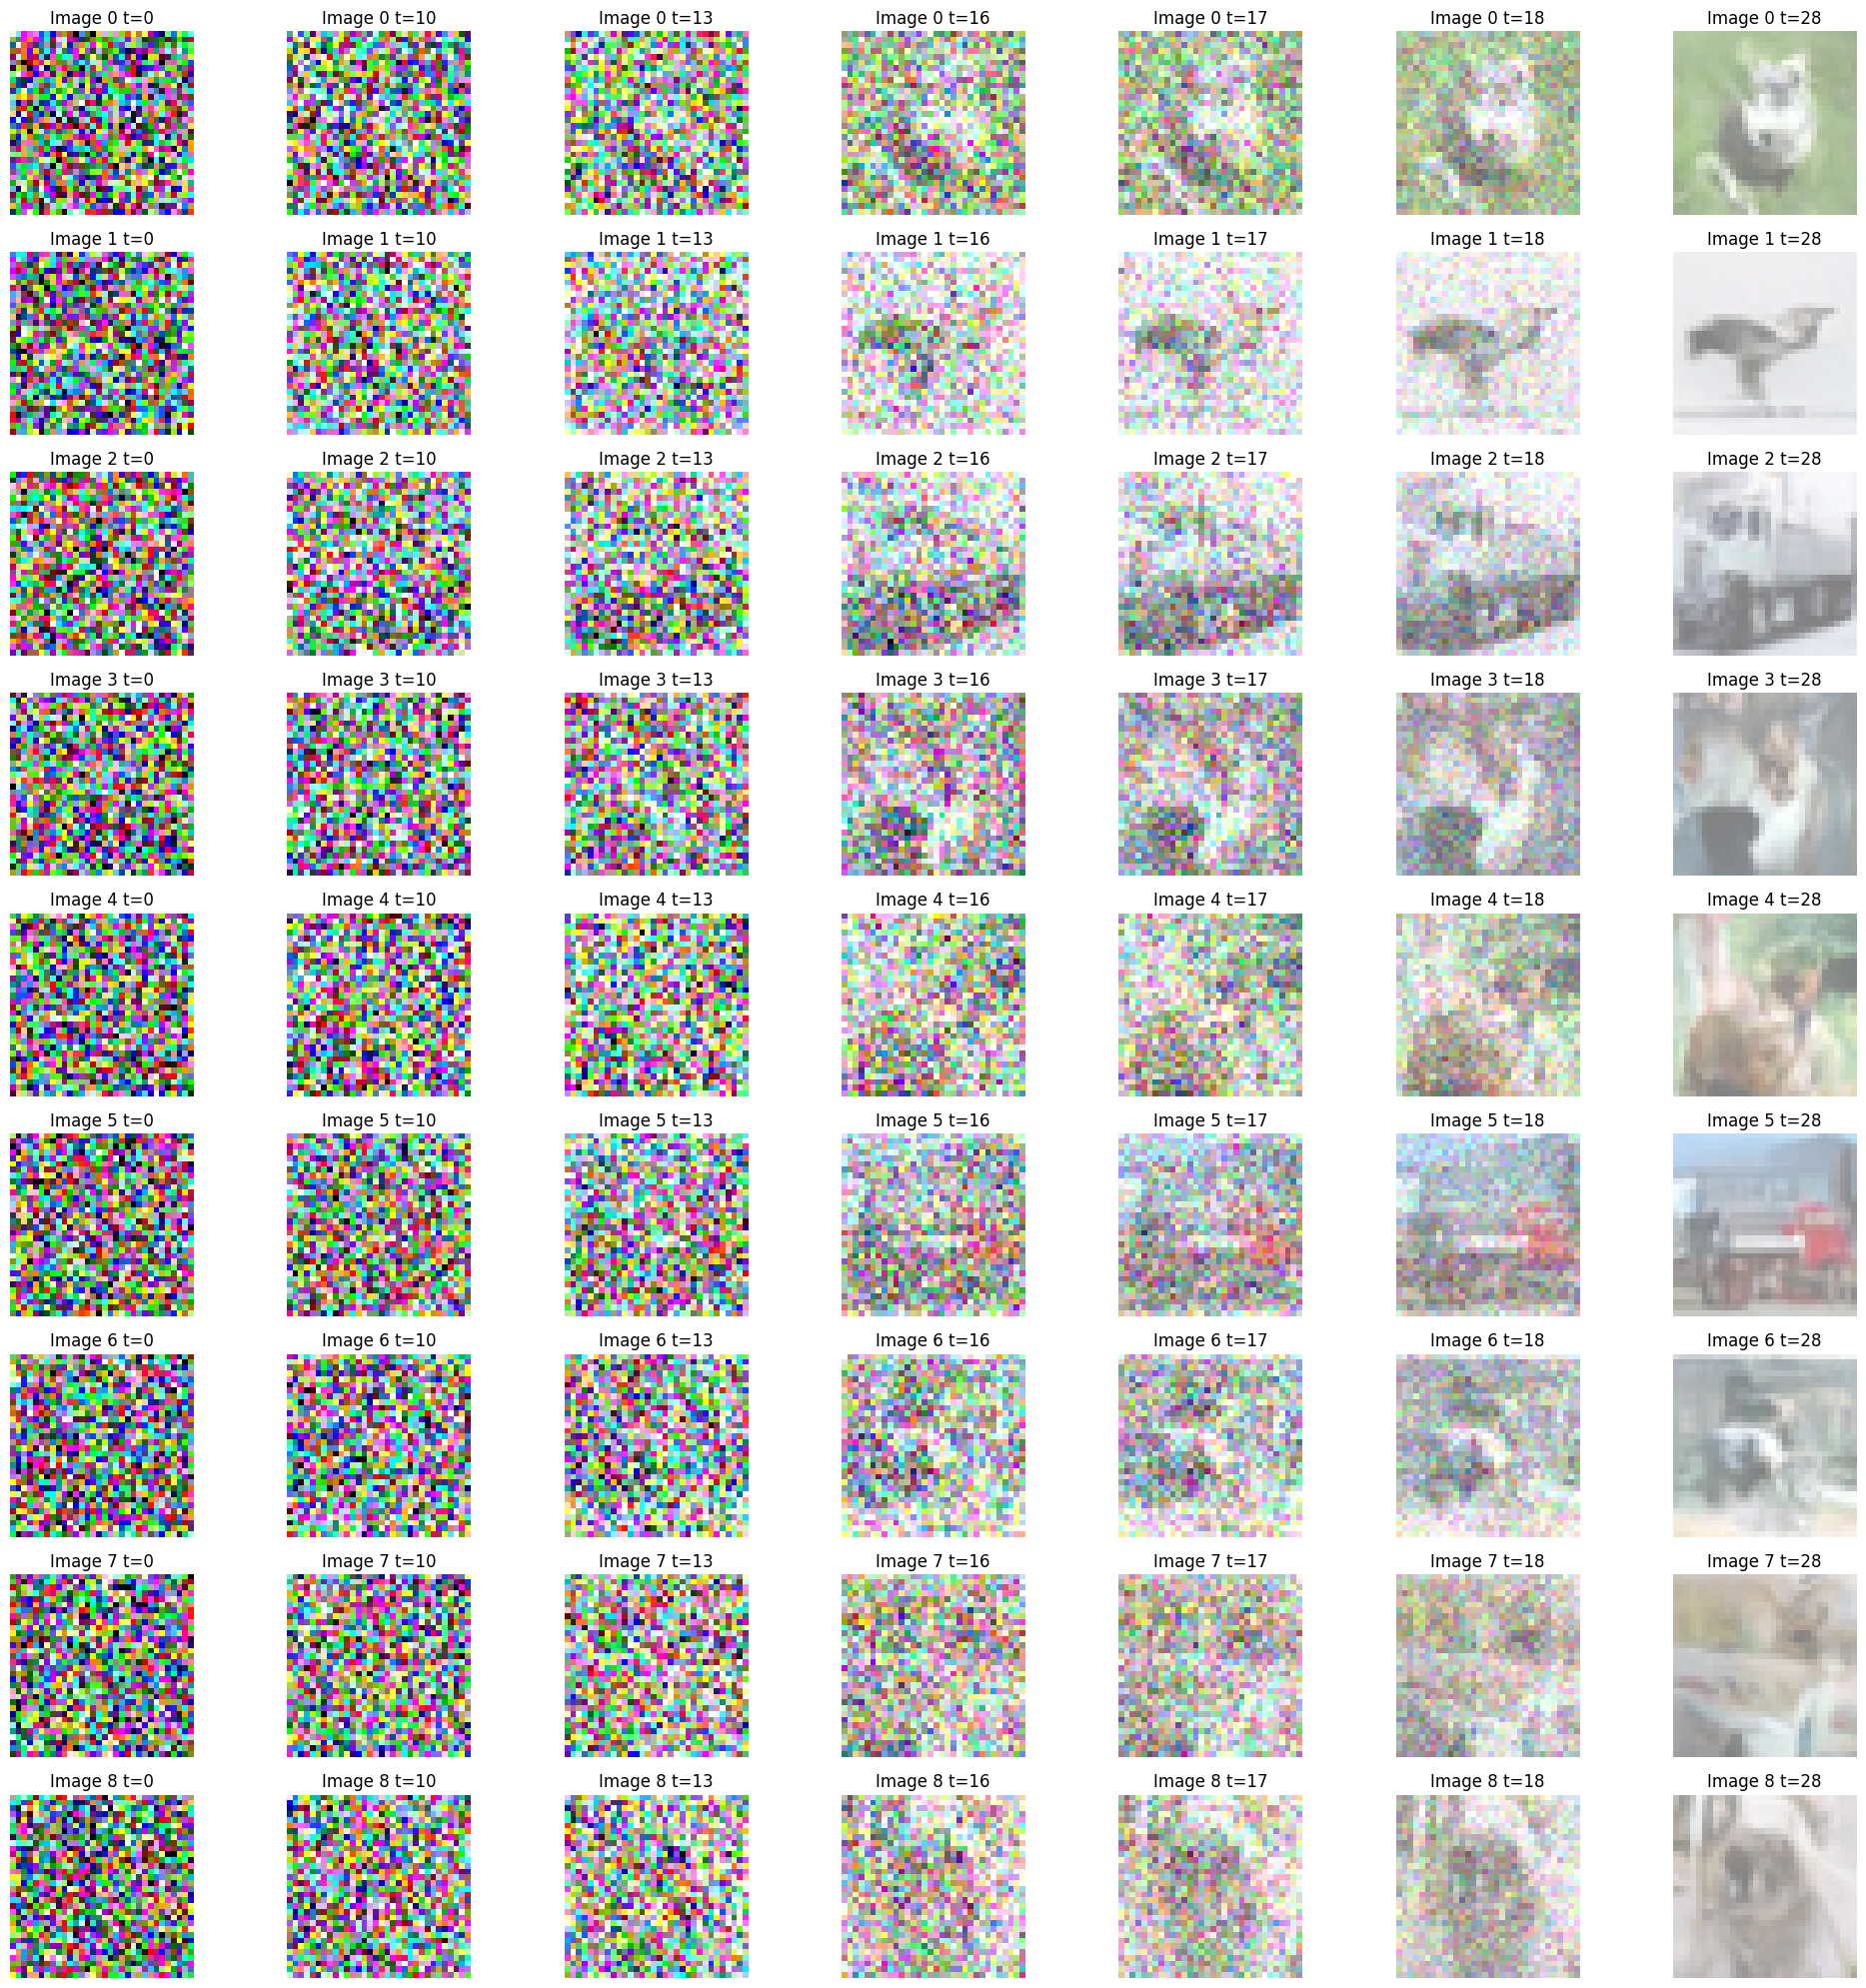

In [52]:
# Affichage des images générées sur serveur suite à l'entraînement
plt.figure(figsize=(20, 20))
folder = "images_diffusion/CIFAR10/1000epochs"
for i in range(9):
    plt.subplot(9, 7, i*7+1)
    image = np.array(Image.open(f"{folder}/sample{i}_time0.png"))
    plt.imshow(image)
    plt.title(f"Image {i} t=0")
    plt.axis("off")
    plt.subplot(9, 7, i*7+2)
    image = np.array(Image.open(f"{folder}/sample{i}_time10.png"))
    plt.imshow(image)
    plt.title(f"Image {i} t=10")
    plt.axis("off")
    plt.subplot(9, 7, i*7+3)
    image = np.array(Image.open(f"{folder}/sample{i}_time13.png"))
    plt.imshow(image)
    plt.title(f"Image {i} t=13")
    plt.axis("off")
    plt.subplot(9, 7, i*7+4)
    image = np.array(Image.open(f"{folder}/sample{i}_time16.png"))
    plt.imshow(image)
    plt.title(f"Image {i} t=16")
    plt.axis("off")
    plt.subplot(9, 7, i*7+5)
    image = np.array(Image.open(f"{folder}/sample{i}_time17.png"))
    plt.imshow(image)
    plt.title(f"Image {i} t=17")
    plt.axis("off")
    plt.subplot(9, 7, i*7+6)
    image = np.array(Image.open(f"{folder}/sample{i}_time18.png"))
    plt.imshow(image)
    plt.title(f"Image {i} t=18")
    plt.axis("off")
    plt.subplot(9, 7, i*7+7)
    image = np.array(Image.open(f"{folder}/sample{i}_time28.png"))
    plt.imshow(image)
    plt.title(f"Image {i} t=28")
    plt.axis("off")
plt.tight_layout()

In [43]:
# Génération de nouvelles images avec le modèle entraîné
n_hold_final = 10
model = DiffusionModel(1000).eval().to(device)
checkpoint = torch.load("models/diffusion_1000e.pt")
model.load_state_dict(checkpoint['model_state_dict'])
gen_samples = []
x = torch.randn((10, 3, 32, 32))
sample_steps = torch.arange(model.t_range - 1, 0, -1)
for t in tqdm(sample_steps):
    x = model.denoise_sample(x.to(device), t.to(device))
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
clamped_samples = (gen_samples.clamp(-1, 1) + 1) / 2
clamped_samples.shape

  0%|          | 0/999 [00:00<?, ?it/s]

torch.Size([29, 10, 32, 32, 3])

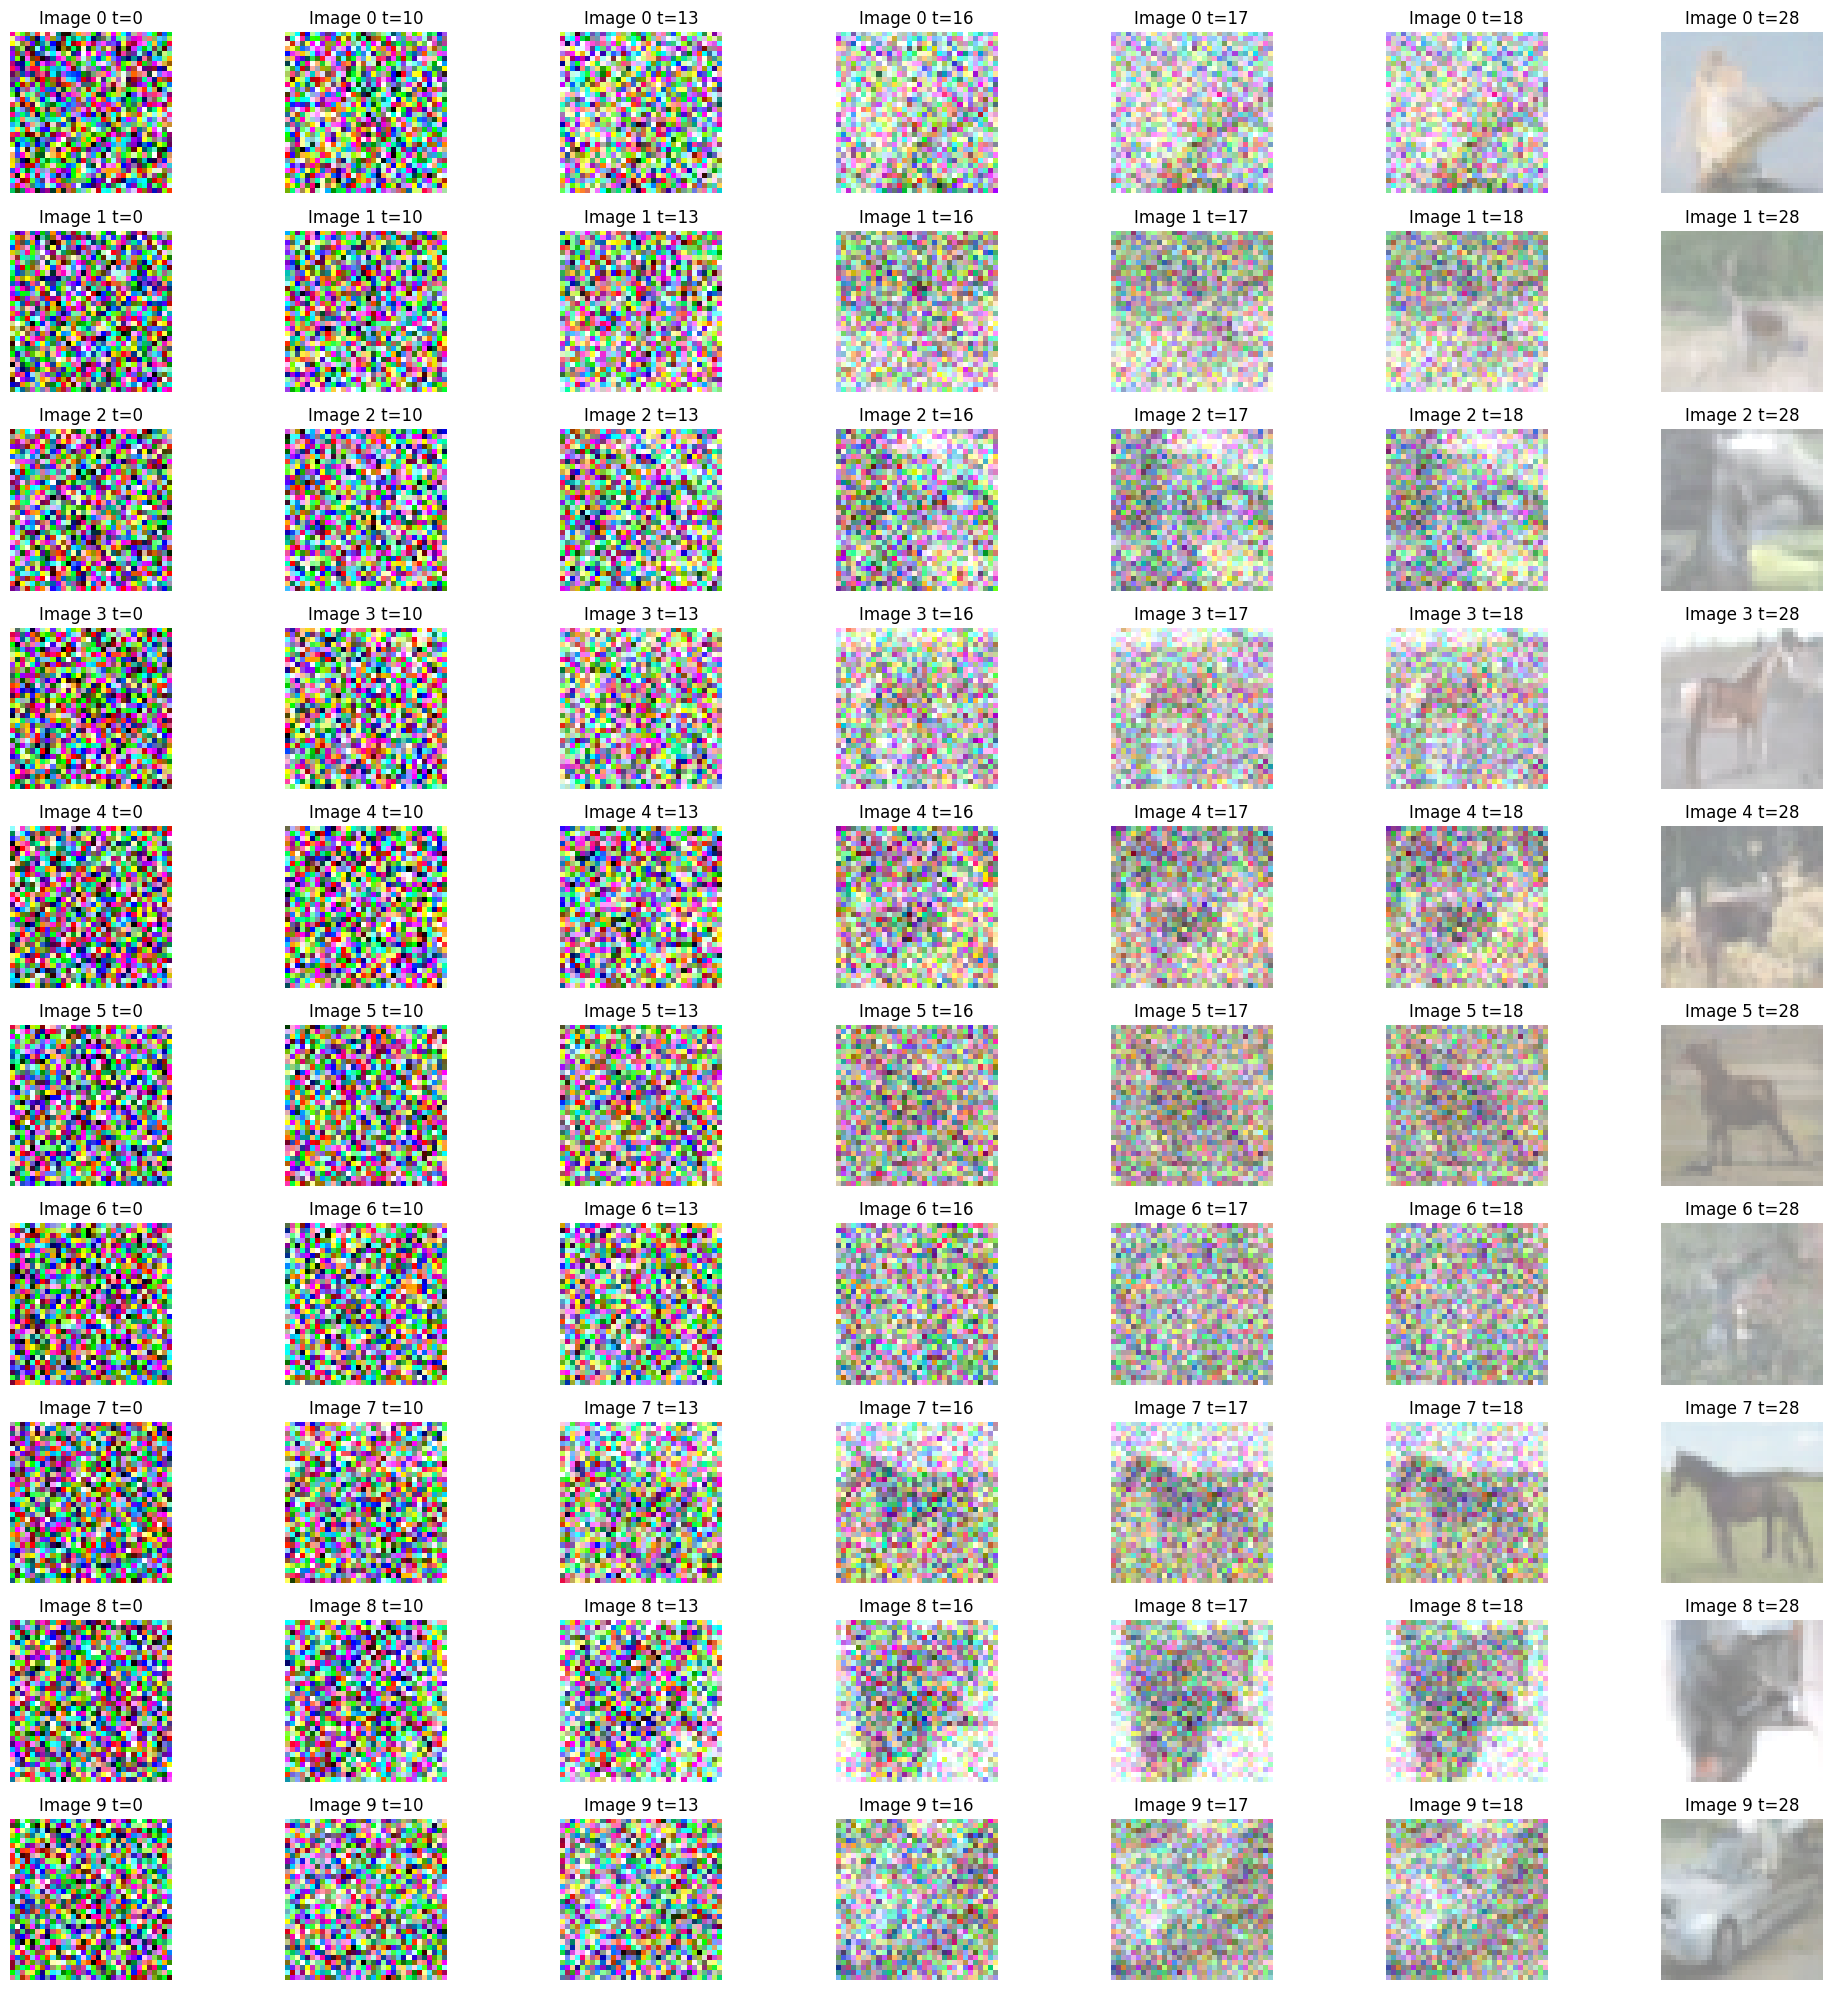

In [51]:
plt.figure(figsize=(20, 20))
folder = "images_diffusion/CIFAR10/1000epochs"
for i in range(10):
    plt.subplot(10, 7, i*7+1)
    image = clamped_samples[0, i].cpu()
    plt.imshow(image)
    plt.title(f"Image {i} t=0")
    plt.axis("off")
    plt.subplot(10, 7, i*7+2)
    image = clamped_samples[10, i].cpu()
    plt.imshow(image)
    plt.title(f"Image {i} t=10")
    plt.axis("off")
    plt.subplot(10, 7, i*7+3)
    image = clamped_samples[13, i].cpu()
    plt.imshow(image)
    plt.title(f"Image {i} t=13")
    plt.axis("off")
    plt.subplot(10, 7, i*7+4)
    image = clamped_samples[16, i].cpu()
    plt.imshow(image)
    plt.title(f"Image {i} t=16")
    plt.axis("off")
    plt.subplot(10, 7, i*7+5)
    image = clamped_samples[17, i].cpu()
    plt.imshow(image)
    plt.title(f"Image {i} t=17")
    plt.axis("off")
    plt.subplot(10, 7, i*7+6)
    image = clamped_samples[17, i].cpu()
    plt.imshow(image)
    plt.title(f"Image {i} t=18")
    plt.axis("off")
    plt.subplot(10, 7, i*7+7)
    image = clamped_samples[28, i].cpu()
    plt.imshow(image)
    plt.title(f"Image {i} t=28")
    plt.axis("off")
plt.tight_layout()